In [2]:
import warnings, numpy as np, pandas as pd, yfinance as yf
warnings.filterwarnings('ignore')

In [3]:
# Set graphics to dark mode
import matplotlib.pyplot as plt, matplotlib as npl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor='#313233', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor='#313233', edgecolor='#313233')
plt.rc('text', color='#C9C9C9')

In [5]:
yf.download('EURUSD=X')

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0
...,...,...,...,...,...,...
2024-03-13,1.092777,1.094931,1.092049,1.092777,1.092777,0
2024-03-14,1.095530,1.095470,1.088412,1.095530,1.095530,0
2024-03-15,1.088341,1.090156,1.087382,1.088341,1.088341,0


In [6]:
# Set standard format for data
def preprocessing_yf(symbol):
    df = yf.download(symbol).dropna() # import data and drop empty rows
    df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume'] # rename
    del df['adj close'] # remove column adj close
    return df

df = preprocessing_yf('EURUSD=X')
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0
...,...,...,...,...,...
2024-03-13,1.092777,1.094931,1.092049,1.092777,0
2024-03-14,1.095530,1.095470,1.088412,1.095530,0
2024-03-15,1.088341,1.090156,1.087382,1.088341,0


<Axes: xlabel='Date'>

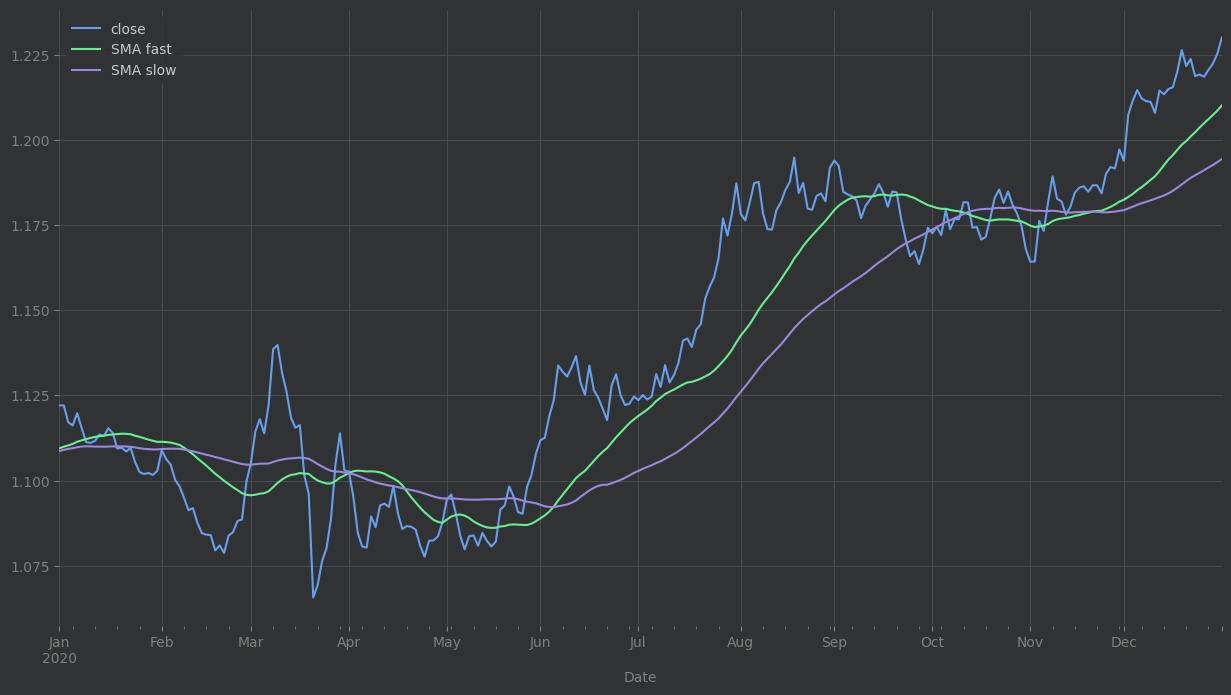

In [7]:
# Creating simple MA's

df['SMA fast'] = df['close'].rolling(30).mean() # close prices of 30 days
df['SMA slow'] = df['close'].rolling(60).mean() # close prices of 60 days

# Plot the resulting MA's
df[['close', 'SMA fast', 'SMA slow']].loc['2020'].plot(figsize=(15,8))

In [8]:
# Simple MA crossover trading signal

df['signal']=np.nan # create empty column for the signals

# conditions => crossovers
condition_buy = (df['SMA fast']>df['SMA slow']) & (df['SMA fast'].shift(1)<df['SMA slow'].shift(1))
condition_sell = (df['SMA fast']<df['SMA slow']) & (df['SMA fast'].shift(1)>df['SMA slow'].shift(1))

df.loc[condition_buy, "signal"] = 1
df.loc[condition_sell, "signal"] = -1

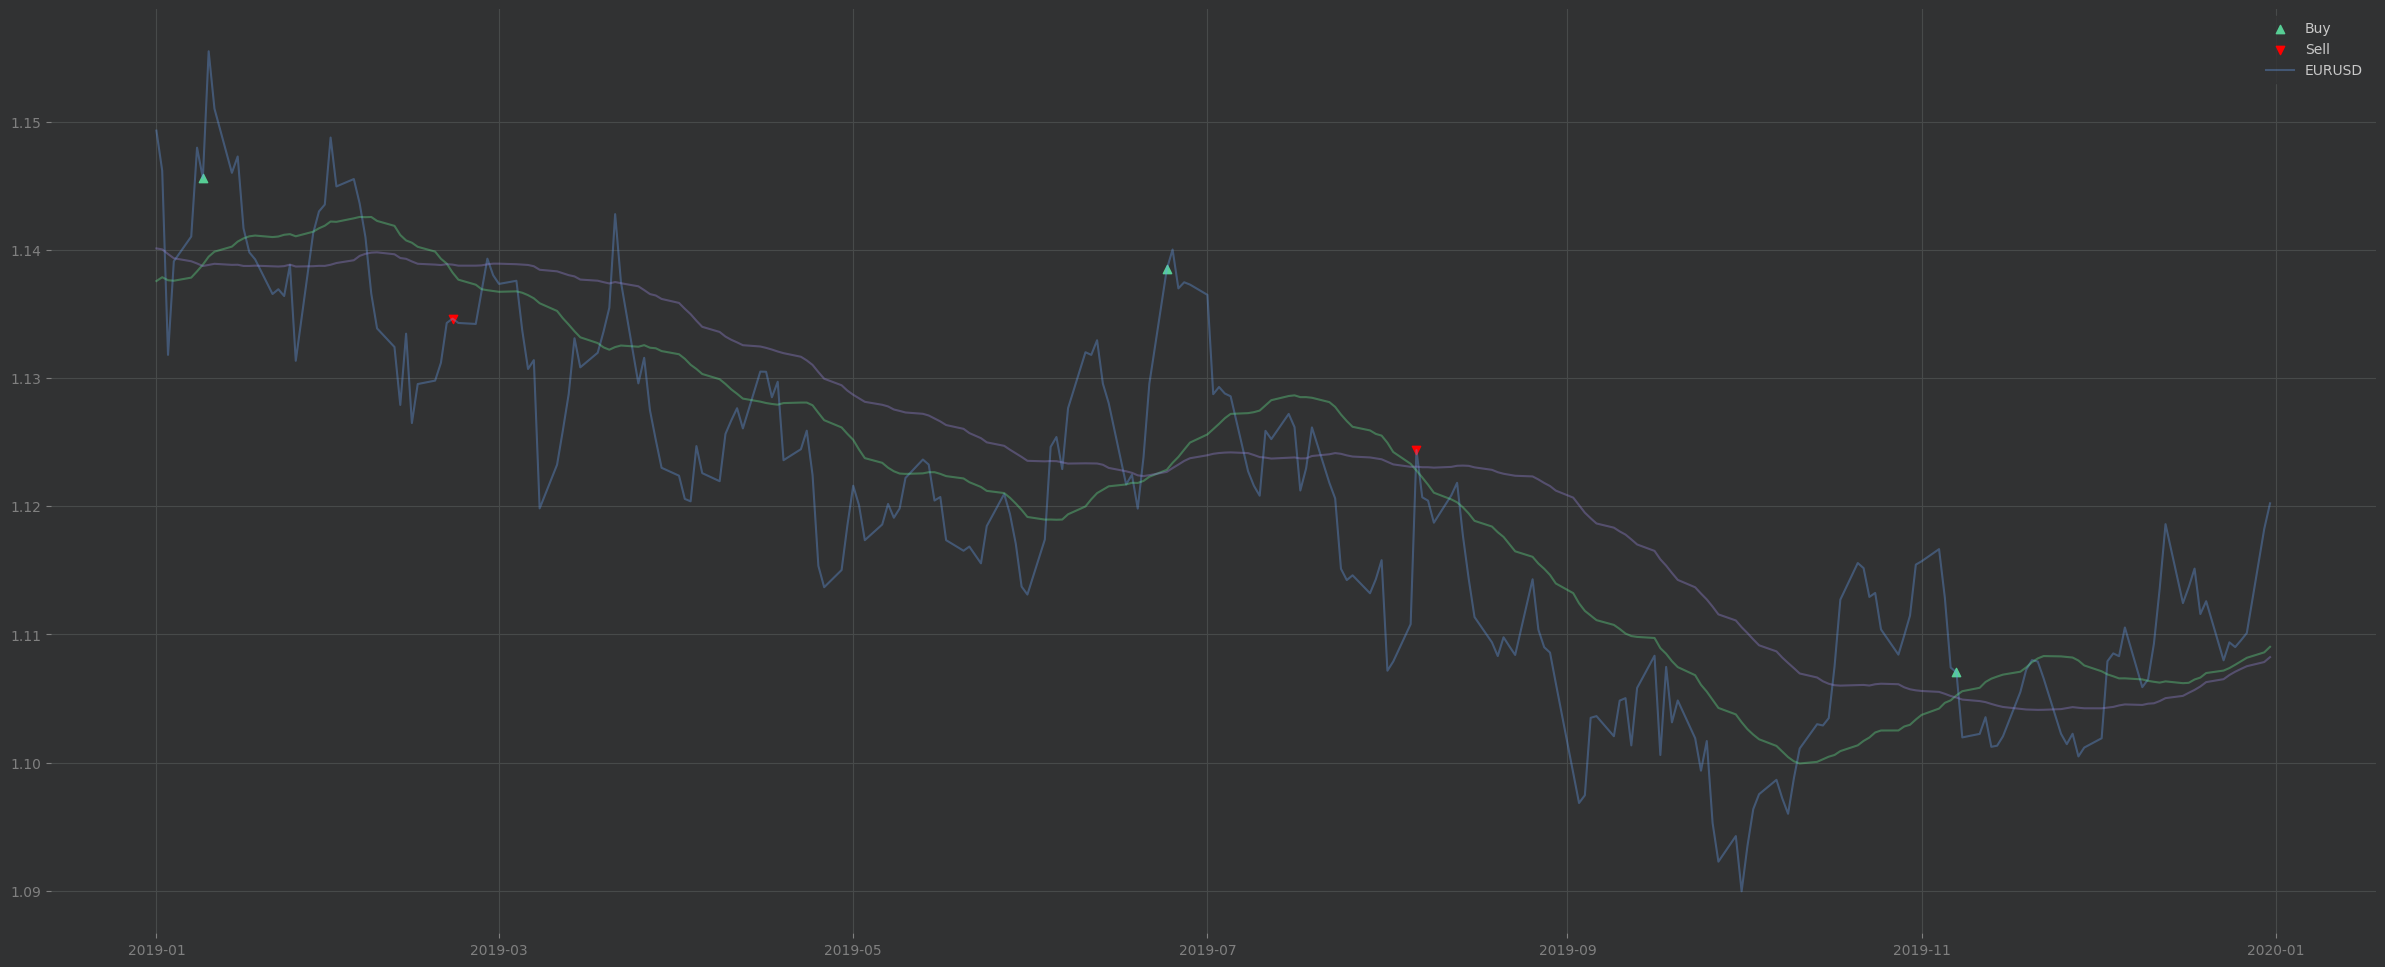

In [11]:
# Plot signals to check execution
year = '2019'

# Select signals in an index list to plot only its points
idx_open = df.loc[df['signal'] == 1].loc[year].index
idx_close = df.loc[df['signal'] == -1].loc[year].index

# Adapt size of graph
plt.figure(figsize=(30,12))

# Plot the points. open=>green, close=>red
plt.scatter(idx_open, df.loc[idx_open]['close'].loc[year], color='#57CE95', marker='^')
plt.scatter(idx_close, df.loc[idx_close]['close'].loc[year], color='red', marker='v')

# Plot the resistance to be sure that the conditions are completed
plt.plot(df['close'].loc[year].index, df['close'].loc[year], alpha=0.35)
plt.plot(df['close'].loc[year].index, df['SMA fast'].loc[year], alpha=0.35)
plt.plot(df['close'].loc[year].index, df['SMA slow'].loc[year], alpha=0.35)
plt.legend(['Buy', 'Sell', 'EURUSD'])

plt.show()

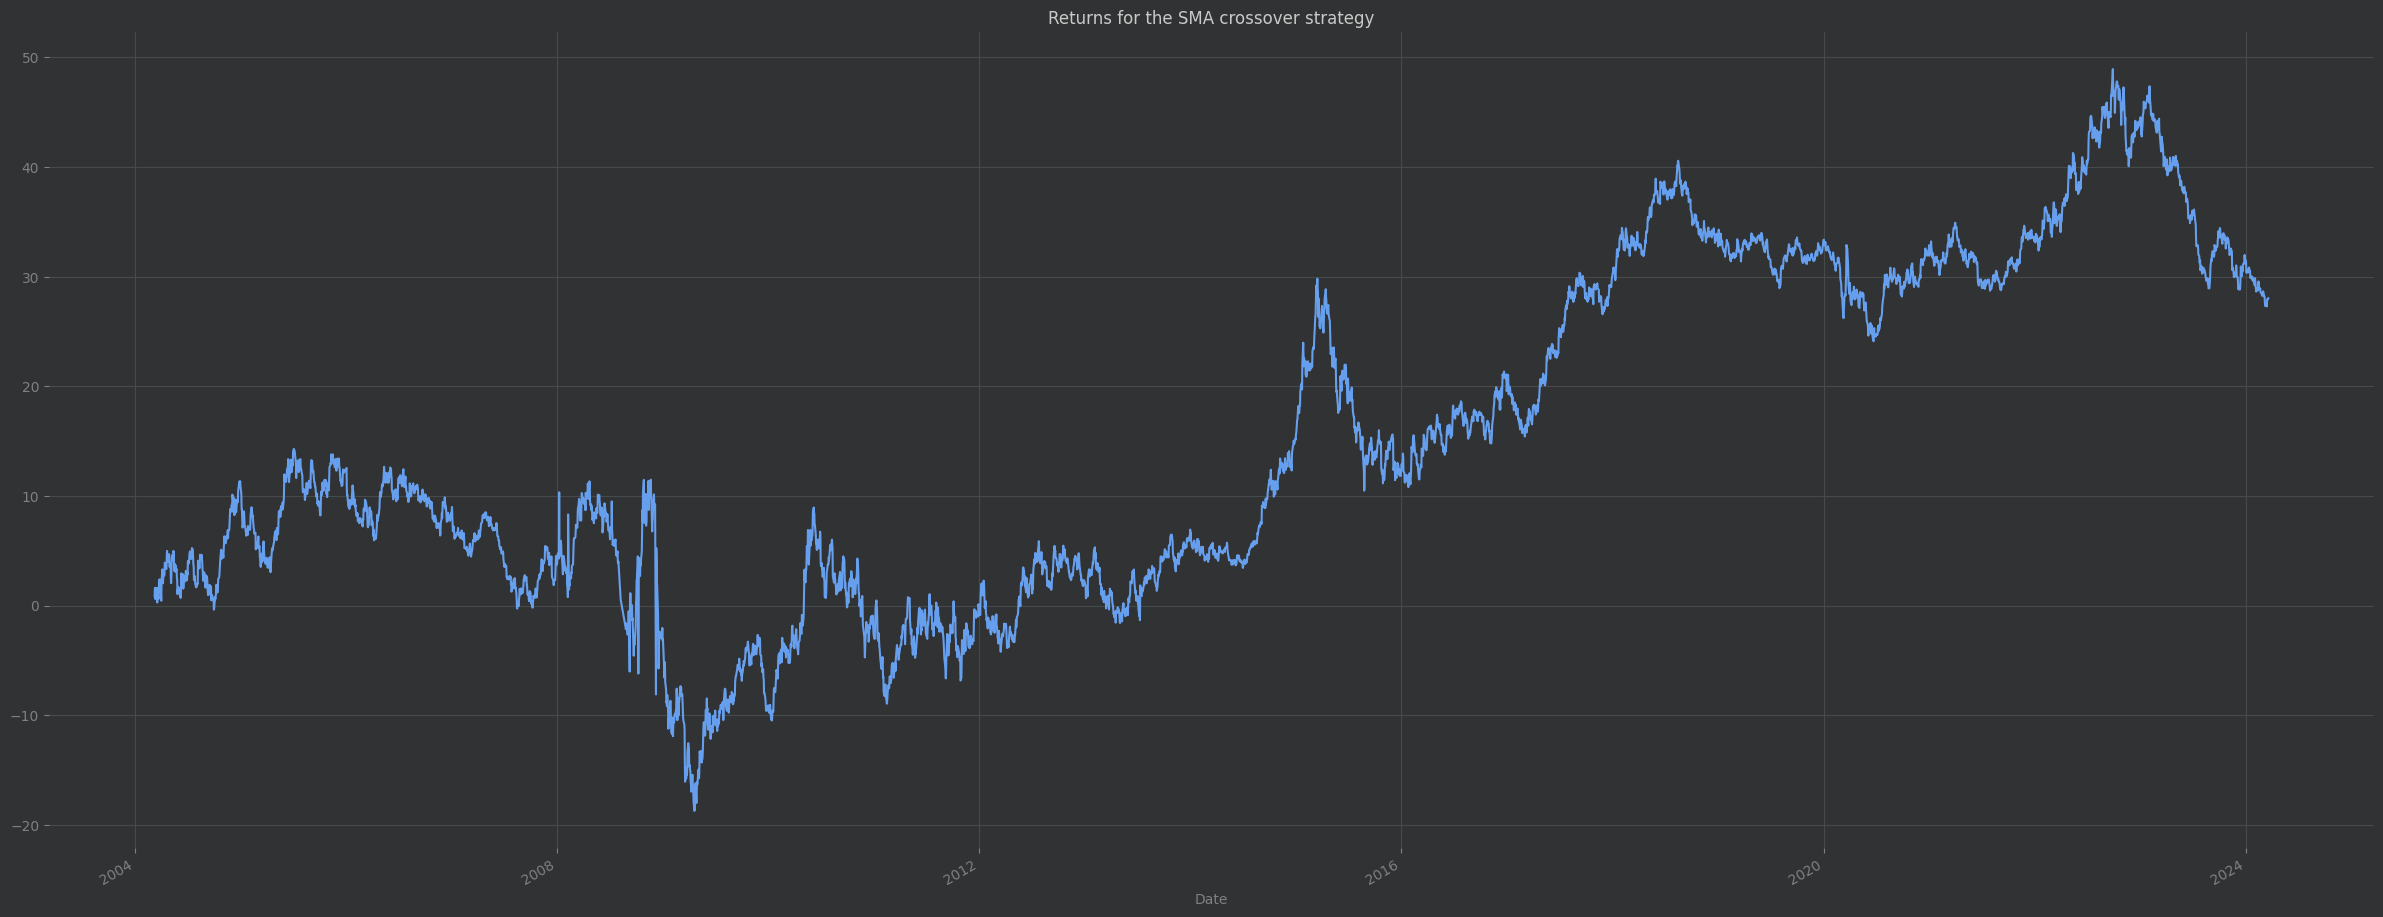

In [12]:
# In computing P&L, 'signal' signifies the open and close position during trade.
df['position'] = df['signal'].fillna(method='ffill')
cost_ind = 0.0001
df['cost'] = (np.abs(df['signal']) * cost_ind).fillna(value=0) # Vector of cost
df['pct'] = df['close'].pct_change(1) # %age of asset variation
df['return'] = (df['pct'] * df['position'].shift(1) - df['cost'])*100 # returns of the strategy

df['return'].cumsum().plot(figsize=(30,12), title='Returns for the SMA crossover strategy')
plt.show()

In [15]:
def SMA_strategy(input, fast_sma=30, slow_sma=60, cost_ind=0.001):
    """Automates creation and testing of the sma crossover strategy
    on data pricefeed of any asset pair."""
    df = preprocessing_yf(input)

    df['SMA fast'] = df['close'].rolling(fast_sma).mean()
    df['SMA slow'] = df['close'].rolling(slow_sma).mean()
    df['signal'] = np.nan

    condition_buy = (df['SMA fast']>df['SMA slow']) & (df['SMA fast'].shift(1)<df['SMA slow'].shift(1))
    condition_sell = (df['SMA fast']<df['SMA slow']) & (df['SMA fast'].shift(1)>df['SMA slow'].shift(1))

    df.loc[condition_buy, "signal"] = 1
    df.loc[condition_sell, "signal"] = -1

    df['position'] = df['signal'].fillna(method='ffill')
    df['cost'] = (np.abs(df['signal']) * cost_ind).fillna(value=0)
    df['pct'] = df['close'].pct_change(1)
    df['return'] = (df['pct'] * df['position'].shift(1) - df['cost'])*100
    
    return df['return']


[*********************100%%**********************]  1 of 1 completed


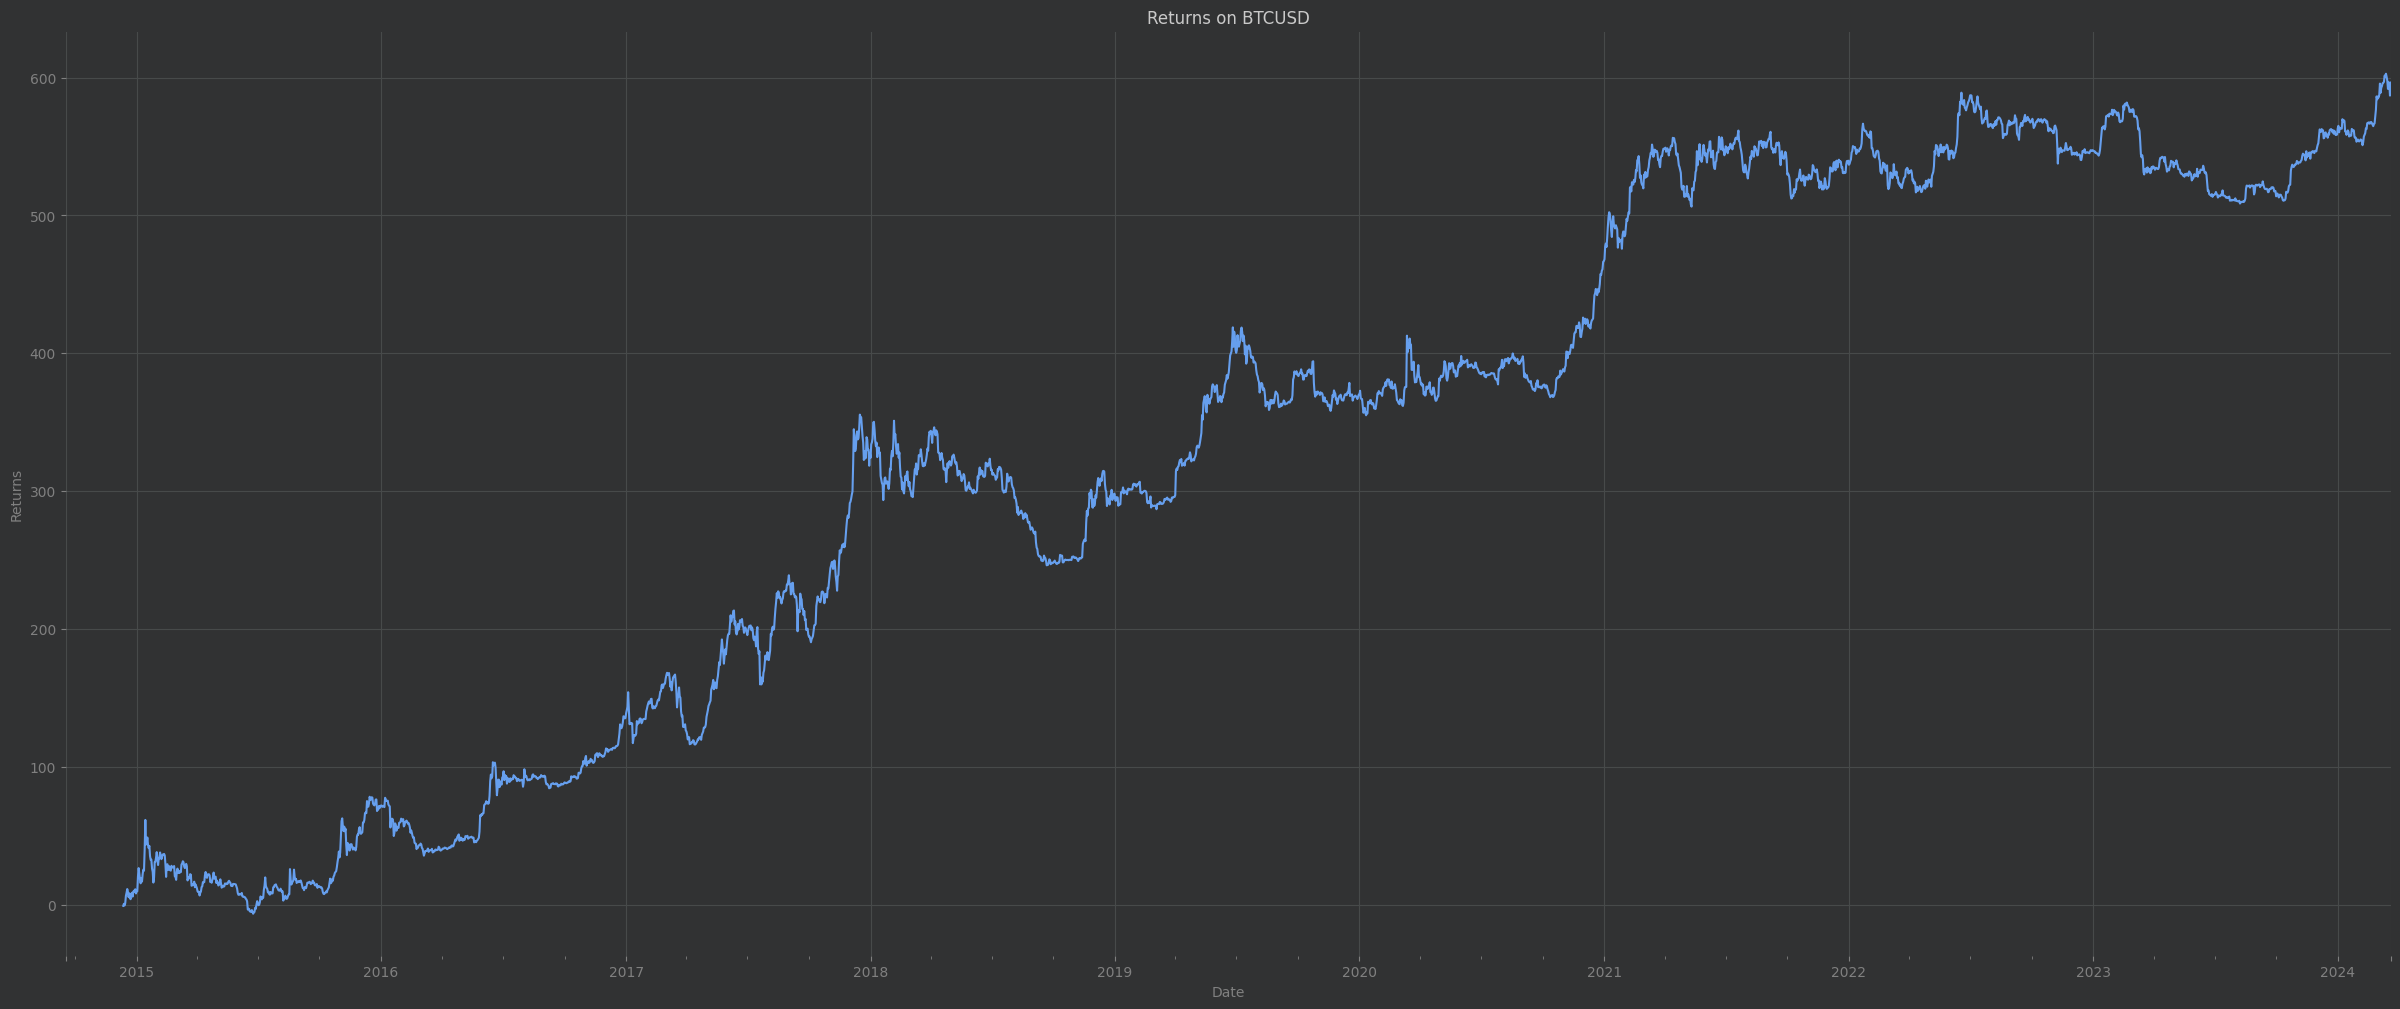

In [19]:
# Plot strategy returns.
SMA_strategy('BTC-USD', 10,60,0.001).cumsum().plot(figsize=(30,12), title='Returns on BTCUSD', ylabel='Returns', xlabel='Date')
plt.show()